In [1]:
def get_trading_date_n(date, idx_close, n, verbose=False):
  """
  Retrieves the trading date n days away from the input date, if it exists in the closing price index.

  Args:
      date (datetime): The starting date.
      idx_close (dict or Series): Date index of close prices.
      n (int): Number of days to move (positive for future, negative for past).
      verbose (bool, optional): Print debug information. Defaults to False.

  Returns:
      datetime or None: The trading date n days away from the input date, or None if not found.
  """

  # Check if the input date is present in the closing price index.
  if date in idx_close:
    # Calculate the index of the date n days away from the input date.
    idx_date_n = idx_close.get_loc(date) + n

    # Check if the calculated index is within the bounds of the closing price index.
    if 0 <= idx_date_n <= len(idx_close) - 1:
      # Retrieve the date n days away.
      date_n = idx_close[idx_date_n]

      if verbose:
        print(f"Retrieving date {n} days away: {date_n}")
    else:
      date_n = None
      if verbose:
        print(f"Date {n} days away is out of bounds.")
  else:
    date_n = None
    if verbose:
      print(f"Input date {date} not found in idx_close.")

  return date_n


In [2]:
def any_not_in_list(list1, list2):
  """
  Determines if any items in list1 are not present in list2.

  Args:
    list1: The first list of items.
    list2: The second list of items.

  Returns:
    True if any item in list1 is not found in list2, False otherwise.
  """

  # Create sets from the lists for efficient difference calculation.
  set1 = set(list1)
  set2 = set(list2)

  # Check for items in list1 that are not in list2 by using set difference.
  # If the difference is not empty, there are items in list1 not in list2.
  return bool(set1 - set2)

In [3]:
def is_date_in_close(date, df_close):
  """
  Determines if a given date is present in a DataFrame's index, considering only the date portion (YYYY-MM-DD).

  Args:
    date (str): The date to check in the format YYYY-MM-DD.
    df_close (pandas.DataFrame): A DataFrame containing a date index.

  Returns:
    str or None: The input date if found in the index, otherwise None.
  """

  # Format the index to YYYY-MM-DD for comparison, ensuring consistent string format.
  formatted_idx_close = df_close.index.strftime('%Y-%m-%d')

  # Check if the input date is present in the formatted index.
  if date in formatted_idx_close:
    # If found, return the date to confirm its presence.
    return date
  else:
    # If not found, return None to indicate its absence.
    return None

In [4]:
import numpy as np  # Import necessary libraries at the beginning
from ast import literal_eval

def calc_portf_shares(df_close, date, str_symbols, portf_target):
  """
  Calculates the number of shares to buy for each symbol in a portfolio to meet a target investment value.

  Args:
    df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
    date (str): The date for which to calculate shares.
    str_symbols (str): String representation of a list of symbols to include in the portfolio.
    portf_target (float): The total target investment value for the portfolio.

  Returns:
    numpy.ndarray: An array containing the number of shares to buy for each symbol.
  """

  # 1. Convert string representation of symbols to a list
  l_syms = literal_eval(str_symbols)

  # 2. Retrieve closing prices for the specified symbols on the given date
  ar_price = df_close.loc[date][l_syms].values

  # 3. Calculate the target investment amount per symbol
  amt_per_sym = portf_target / len(l_syms)  # Calculate directly using len(l_syms)

  # 4. Calculate the number of shares to buy for each symbol, rounding down to whole shares
  ar_shares = np.floor(amt_per_sym / ar_price)

  return ar_shares

In [5]:
import numpy as np  # Import at the beginning for better organization
from ast import literal_eval

def calc_portf_value(df_close, date, str_symbols, ar_shares, verbose=False):
  """
  Calculates the total value of a portfolio of stocks for a given date.

  Args:
    df_close (pandas.DataFrame): DataFrame containing closing prices, indexed by date and symbols.
    date (str): The date for which to calculate the portfolio value.
    str_symbols (str): String representation of a list of symbols in the portfolio.
    ar_shares (numpy.ndarray): Array containing the number of shares held for each symbol.
    verbose (bool, optional): If True, prints details of the calculation. Defaults to False.

  Returns:
    tuple: A tuple containing the date, symbols, closing prices, shares, individual symbol values, and total portfolio value.
  """

  # 1. Convert string representation of symbols to a list
  l_syms = literal_eval(str_symbols)

  # 2. Retrieve closing prices for the specified symbols on the given date
  ar_price = df_close.loc[date][l_syms].values

  # 3. Calculate the dollar value invested in each symbol
  ar_value = ar_price * ar_shares

  # 4. Calculate the total portfolio value
  portf_value = sum(ar_value)  # Directly calculate the total value

  # 5. Print details if verbose is True
  if verbose:
    print(f"Portfolio value details:\n"
          f"- Date: {date}\n"
          f"- Symbols: {l_syms}\n"
          f"- Closing prices: {ar_price}\n"
          f"- Shares: {ar_shares}\n"
          f"- Individual symbol values: {ar_value}\n"
          f"- Total portfolio value: {portf_value}")

  # 6. Return the calculated values
  return date, l_syms, ar_price, ar_shares, ar_value, portf_value

In [6]:
def calc_portf_value_date_buy(idx_date, str_symbols, df_close, portf_target, n, verbose=False):
  """
  Calculates portfolio values for multiple dates and symbol combinations, handling potential data gaps.

  Args:
    idx_date (list): List of dates (str) to evaluate portfolios.
    str_symbols (list): List of symbol lists (str) to evaluate for each date.
    df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
    portf_target (float): Target portfolio value for allocation.
    n (int): Number of trading days to offset execution from the lookback date.
    verbose (bool, optional): If True, prints details. Defaults to False.

  Returns:
    tuple: Tuple containing lists of buy dates, shares, and portfolio values for both the selected symbols and SPY.
  """

  from ast import literal_eval

  # Extract trading dates and symbols from the DataFrame
  idx_close = df_close.index.strftime('%Y-%m-%d')  # Trading dates in format YYYY-MM-DD
  symbols_df_close = df_close.columns  # Symbols in df_close

  # Initialize lists to store results
  date_exec = []  # Buy date of portfolio
  shares_syms = []  # Lists of shares of each symbol bought on each date
  value_portf = []  # List of portfolio values on each date
  shares_SPY = []  # List of shares of SPY bought on each date
  value_SPY = []  # List of values of SPY shares on each date

  # Iterate through pairs of dates and symbol lists
  for date, syms in zip(idx_date, str_symbols):

    # Determine the execution date based on the lookback date and the offset n
    next_date_n = get_trading_date_n(date, idx_close, n, verbose=False)
    close_date_n = is_date_in_close(next_date_n, df_close)

    # Print information for debugging
    print(f'++++++++++++++')
    print(f'date: {date}')
    print(f'n (days increment): {n}')         
    print(f'next_date_n: {next_date_n}')
    print(f'close_date_n: {close_date_n}')
    print(f'syms: {syms}')
    print(f'++++++++++++++')    

    #TODO ??? l_syms overwrite l_syms ???     
    # Convert string representation of symbols back to a list
    l_syms = literal_eval(syms)
    # print(f'syms: {syms}, l_syms: {l_syms}')
    #TODO ??? l_syms overwrite l_syms ???         

    # Check if any symbols are not present in the DataFrame
    sym_not_in_df_close = any_not_in_list(l_syms, symbols_df_close)

    if close_date_n is None or sym_not_in_df_close:
      # Handle missing data:
      print(f'l_syms: {l_syms}')  
      ## print(f'sym_not_in_df_close: {sym_not_in_df_close}')  
      print(f'l_syms are in df_close: {not sym_not_in_df_close}')        

      p_date = None
      p_ar_shares = None
      p_portf_value = None  # Set to None when data are not available
      SPY_shares = None
      SPY_value = None  # Set to None when data are not available

      if verbose:
        print(f"No data for close_date_n {close_date_n}, pick's portf value = None")
        print(f'No data for close_date_n {close_date_n}, SPY portf value =    None')

    else:
      # Calculate portfolio values when data is available:
      p_ar_shares = calc_portf_shares(df_close, close_date_n, syms, portf_target)
      p_date, _l_syms, _ar_price, _ar_shares, _ar_value, p_portf_value = calc_portf_value(df_close, close_date_n, syms, p_ar_shares, verbose)

      syms = str(['SPY'])
      SPY_shares = calc_portf_shares(df_close, close_date_n, syms, portf_target)
      _date, l_syms, _ar_price, _ar_shares, _ar_value, SPY_value = calc_portf_value(df_close, close_date_n, syms, SPY_shares, verbose)

      if verbose:
        print(f"close_date_n pick's portf value = {p_portf_value}")
        print(f'close_date_n SPY portf value =    {SPY_value}')

    date_exec.append(p_date)
    shares_syms.append(p_ar_shares)
    value_portf.append(p_portf_value)
    shares_SPY.append(SPY_shares)
    value_SPY.append(SPY_value)

    print('='*20, '\n')

  return date_exec, shares_syms, value_portf, shares_SPY, value_SPY

In [7]:
def calc_portf_value_date_n(idx_date, str_symbols, df_close, my_portf_shares, my_SPY_shares, n, verbose=False):
  """
  Calculates portfolio values for multiple dates and symbol combinations, taking pre-determined shares as input.

  Args:
    idx_date (list): List of dates (str) to evaluate portfolios.
    str_symbols (list): List of symbol lists (str) to evaluate for each date.
    df_close (pandas.DataFrame): DataFrame with closing prices, indexed by date and symbols.
    my_portf_shares (list): List of lists of shares for each symbol combination.
    my_SPY_shares (list): List of shares of SPY to evaluate for each date.
    n (int): Number of trading days to offset execution from the lookback date.
    verbose (bool, optional): If True, prints details. Defaults to False.

  Returns:
    tuple: Tuple containing lists of buy dates, shares, and portfolio values for both the selected symbols and SPY.
  """

  # Extract trading dates from the DataFrame
  idx_close = df_close.index.strftime('%Y-%m-%d')  # Trading dates in format YYYY-MM-DD

  # Initialize lists to store results
  date_exec = []  # Buy date of portfolio
  shares_syms = []  # Lists of shares of each symbol bought on each date
  value_portf = []  # List of portfolio values on each date
  shares_SPY = []  # List of shares of SPY bought on each date
  value_SPY = []  # List of values of SPY shares on each date

  # Iterate through pairs of dates, symbol lists, and shares
  for date, symbols, portf_shares, SPY_shares in zip(idx_date, str_symbols, my_portf_shares, my_SPY_shares):

    # Determine the execution date based on the lookback date and the offset n
    next_date_n = get_trading_date_n(date, idx_close, n, verbose=False)
    close_date_n = is_date_in_close(next_date_n, df_close)

    # Print information for debugging
    print(f'++++++++++++++')
    print(f'date: {date}')
    print(f'n (days increment): {n}')        
    print(f'next_date_n: {next_date_n}')
    print(f'close_date_n: {close_date_n}')
    print(f'symbols: {symbols}')
    print(f'++++++++++++++')   


    if close_date_n is None or portf_shares is None:
      # Handle missing data or missing shares:
      p_date_exec = None
      p_ar_shares = None
      p_value_portf = None  # Set to None when data or shares are unavailable
      SPY_ar_shares = None
      SPY_value_portf = None  # Set to None when data or shares are unavailable

      if verbose:
        print(f"No data for close_date_n {close_date_n}, pick's portf value = None")

    else:
      # Calculate portfolio values when data and shares are available:
      p_date_exec, _p_ar_syms, _p_ar_price, p_ar_shares, _p_ar_value, p_value_portf = calc_portf_value(df_close, close_date_n, symbols, portf_shares, verbose)

      SPY = str(['SPY'])  # Calculate SPY portfolio value separately
      _SPY_date_exec, _SPY_ar_syms, _SPY_ar_price, SPY_ar_shares, _SPY_ar_value, SPY_value_portf = calc_portf_value(df_close, close_date_n, SPY, SPY_shares, verbose)

      if verbose:
        print(f"next_date_n pick's portf value = {p_value_portf}")
        print(f'next_date_n SPY portf value =    {SPY_value_portf}')

    # Append results to lists
    date_exec.append(p_date_exec)
    shares_syms.append(p_ar_shares)
    value_portf.append(p_value_portf)
    shares_SPY.append(SPY_ar_shares)
    value_SPY.append(SPY_value_portf)

    print('='*20, '\n')

  return date_exec, shares_syms, value_portf, shares_SPY, value_SPY

In [8]:
import datetime


def calculate_date_n_days_back(input_date, n_days_back):
  """
  Calculates the date n days back from a given input date.

  Args:
    input_date (datetime.date): The input date.
    n_days_back (int): The number of days back from the input date.

  Returns:
    str: The date n days back from the input date, formatted as 'yyyy-mm-dd'.
  """

  previous_date = input_date - datetime.timedelta(days=n_days_back)
  previous_date_str = previous_date.strftime("%Y-%m-%d")

  return previous_date_str


# if __name__ == "__main__":
#   # Example usage
#   input_date = date.today()  # Replace with your desired date
#   n_days_back = 365*2
#   previous_date_str = calculate_date_n_days_back(input_date, n_days_back)
#   print(f"{input_date} - {n_days_back} days ago: {previous_date_str}")


In [9]:
def get_index_with_missing_values_in_column(df, column_to_check):
  """
  Retrieves the index of rows where a specified column has missing values.

  Args:
      df (pd.DataFrame): The DataFrame to filter.
      column_to_check (str): The name of the column to check for null values.

  Returns:
      pd.Index: The index of rows where the specified column is null.
  """

  return df[df['date_buy'].isnull()].index

In [10]:
def is_monotonic_increasing_by_1(arr):
  """
  Checks if a numpy array is monotonically increasing by 1.

  Args:
    arr: A numpy array.

  Returns:
    True if the array is monotonically increasing by 1, False otherwise.
  """

  # Check if the array is empty or has only one element
  if len(arr) <= 1:
    return True

  # Check if the difference between consecutive elements is 1
  return np.all(np.diff(arr) == 1)

# # Test cases
# arr1 = np.array([1, 2, 3, 4])  # Monotonic increasing
# arr2 = np.array([1, 2, 3, 5, 6])  # Not monotonic
# arr3 = np.array([])  # Empty array

# print(is_monotonic_increasing_by_1(arr1))  # Output: True
# print(is_monotonic_increasing_by_1(arr2))  # Output: False
# print(is_monotonic_increasing_by_1(arr3), '\n')  # Output: True

In [11]:
import pandas as pd  # Explicitly import pandas for clarity

def sort_df_columns(df: pd.DataFrame) -> pd.DataFrame:
  """Sorts a DataFrame in descending order by specified columns.

  Args:
      df: The DataFrame to be sorted.

  Returns:
      The sorted DataFrame.
  """

  # Define the sorting columns and order explicitly
  sorting_columns = ['date', 'days_lookback', 'syms_freq', 'symbols']
  ascending = False  # Descending order for all columns

  # Perform the sorting in a single step with clear variable names
  sorted_df = df.sort_values(by=sorting_columns, ascending=ascending)

  return sorted_df

In [12]:
# Import libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation
import matplotlib.pyplot as plt  # For plotting
import matplotlib.dates as mdates  # For handling dates in plots
from datetime import date, timedelta  # For working with dates
from myUtils import pickle_load, pickle_dump  # For loading and saving data

# Set pandas display options
pd.set_option('display.max_rows', 100)  # Display up to 100 rows
pd.set_option('display.max_columns', 30)  # Display up to 30 columns
pd.set_option('display.max_colwidth', 30)  # Limit column width to 30 characters
pd.set_option('display.width', 900)  # Set overall display width to 900 characters

# Define file paths
path_dir = "C:/Users/ping/MyDrive/stocks/yfinance/"  # Base directory for stock data
path_data_dump = path_dir + "VSCode_dump/"  # Subdirectory for pickled data

# Define file names
fp_df_model_top_picks = 'df_model_top_picks'  # Model's top stock picks
fp_df_close_clean = 'df_close_clean'  # Historic closing prices
fp_df_model_picks_perf = 'df_model_picks_perf'  # Model picks' performance

# Set verbose mode
verbose = True  # Print information during execution if True

In [13]:
"""
Loads pre-processed datasets from pickled files.
"""

# Load the DataFrame containing historical closing prices:
df_close = pickle_load(path_data_dump, fp_df_close_clean)  # Load from the specified pickle file

# Load the DataFrame containing top stock picks from the model:
df_model_picks = pickle_load(path_data_dump, fp_df_model_top_picks)  # Load from the specified pickle file


In [14]:
"""
Extracts and prints information about the date range and length of the df_model_picks DataFrame.
"""

# Extract dates from the DataFrame and sort them chronologically:
dates_sorted = sorted(df_model_picks.date.tolist())  # Create a list of dates and sort them

# Extract the first and last dates to determine the date range:
date_start_model_picks = dates_sorted[0]  # Get the earliest date
date_end_model_picks = dates_sorted[-1]  # Get the latest date

# Print the date range and the number of rows in the DataFrame:
print(f'date_start_model_picks: {date_start_model_picks}')
print(f'date_end_model_picks: {date_end_model_picks}')
print(f'len(df_model_picks): {len(df_model_picks)}')  # Print the length (number of rows)


date_start_model_picks: 2018-07-06
date_end_model_picks: 2024-02-05
len(df_model_picks): 1517


In [15]:
"""
Filters the df_close DataFrame to match the date range of df_model_picks and extracts information.
"""

# Create a boolean mask to filter rows within the desired date range:
mask = (df_close.index >= date_start_model_picks) & (df_close.index <= date_end_model_picks)  # Select rows between the start and end dates

# Apply the mask to filter the DataFrame:
df_close = df_close.loc[mask]  # Keep only rows that meet the date criteria

# Extract trading dates as formatted strings:
idx_close = df_close.index.strftime('%Y-%m-%d')  # Get trading dates in YYYY-MM-DD format

# Extract symbols present in the filtered DataFrame:
symbols_df_close = df_close.columns  # Get a list of symbols in the DataFrame

# Display the filtered DataFrame to verify its contents:
df_close  # Print the DataFrame to view the filtered data

,A,AA,AAL,AAP,AAPL,AB,ABBV,ABR,ABT,ACGL,ACHC,ACIW,ACLS,ACRS,ADBE,...,XRX,XYL,YELP,YUM,YUMC,YY,ZBH,ZBRA,ZD,ZG,ZION,ZTO,ZTS,ZUMZ,ZWS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-06,59.826286,46.141712,37.283417,125.891403,44.790005,18.318947,74.443977,6.375906,56.397491,27.280001,42.250000,26.020000,21.049999,20.490000,248.190002,...,18.737396,62.475842,39.959999,70.938255,35.505920,84.300117,106.129333,148.250000,76.154495,63.009998,44.027050,18.595814,83.533485,23.650000,27.790464
2018-07-09,60.623451,47.267368,38.477585,129.360580,45.411915,18.507805,74.536148,6.375906,56.651527,27.889999,42.950001,26.290001,22.100000,20.799999,249.770004,...,19.221390,63.626049,40.000000,71.753937,35.515423,86.077858,106.743759,149.720001,76.639503,62.410000,45.157455,19.021460,84.139381,24.049999,28.109339
2018-07-10,61.151699,46.875832,38.291603,129.085236,45.357109,18.633703,75.918739,6.346523,56.987236,28.240000,43.090000,26.200001,21.549999,20.730000,248.630005,...,19.413445,63.766327,39.400002,71.880829,34.935390,84.248070,106.874084,149.869995,75.677994,61.700001,44.730408,19.352510,82.918022,23.950001,28.215633
2018-07-11,60.373734,47.042236,35.198517,127.644356,44.768543,18.318947,72.938522,6.428793,56.769478,28.040001,42.939999,26.070000,20.400000,20.889999,248.119995,...,19.213703,62.372971,39.400002,71.409554,34.516998,84.057289,106.278282,146.669998,74.818604,62.450001,44.487583,18.974163,81.263878,23.600000,27.742147
2018-07-12,60.940395,46.396210,35.560684,127.378159,45.519150,18.161568,74.187798,6.428793,57.179596,28.080000,43.310001,26.469999,20.850000,20.430000,254.869995,...,19.328939,63.654102,40.720001,71.708649,34.773743,84.612297,106.166573,149.360001,75.269569,63.779999,44.001923,19.929491,82.196732,21.250000,27.771137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30,134.279999,30.610001,14.530000,67.250000,188.039993,33.959999,164.919998,14.200000,113.480003,80.580002,84.339996,30.879999,133.410004,1.210000,627.960022,...,19.049999,113.750000,45.200001,130.619995,35.119999,29.980000,122.370003,250.910004,69.629997,55.779999,44.439999,16.480000,191.429993,17.740000,30.450001
2024-01-31,130.100006,29.750000,14.230000,66.849998,184.399994,33.549999,164.399994,13.300000,113.150002,82.430000,82.139999,30.070000,130.050003,1.160000,617.780029,...,18.459999,112.440002,43.730000,129.490005,34.590000,30.660000,125.599998,239.550003,67.400002,55.090000,41.900002,16.360001,187.809998,17.170000,29.650000
2024-02-01,133.050003,29.690001,14.340000,69.239998,186.860001,33.720001,167.589996,13.500000,114.489998,82.089996,81.769997,29.709999,130.690002,1.200000,627.909973,...,18.540001,115.379997,44.139999,130.449997,35.470001,31.360001,127.250000,242.600006,68.360001,56.630001,39.250000,16.540001,189.139999,17.889999,30.260000


In [21]:
"""
Displays the first few rows of the df_model_picks DataFrame for a quick overview.
"""

# Sort df by columns to ensure consistency before merging columns from other dfs
sorted_df_model_picks = sort_df_columns(df_model_picks)
print(f'sorted_df_model_picks:\n{sorted_df_model_picks}')

sorted_df_model_picks:
            date  days_lookback   syms_freq   symbols
0     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']
1     2024-02-02  [30, 60, 120]  sym_freq_8   ['SHV']
2     2024-02-01  [30, 60, 120]  sym_freq_9  ['FTSM']
3     2024-01-31  [30, 60, 120]  sym_freq_9   ['SHV']
4     2024-01-30  [30, 60, 120]  sym_freq_9   ['SHV']
...          ...            ...         ...       ...
1512  2018-07-12  [30, 60, 120]  sym_freq_8  ['TNDM']
1513  2018-07-11  [30, 60, 120]  sym_freq_8  ['TNDM']
1514  2018-07-10  [30, 60, 120]  sym_freq_8  ['TNDM']
1515  2018-07-09  [30, 60, 120]  sym_freq_8  ['TNDM']
1516  2018-07-06  [30, 60, 120]  sym_freq_8  ['TNDM']

[1517 rows x 4 columns]


In [17]:
# Load the model picks performance data from the pickle file
df_model_picks_perf = pickle_load(path_data_dump, fp_df_model_picks_perf)

# Sort df by columns to ensure consistency before merging columns from other dfs
sorted_df_model_picks_perf = sort_df_columns(df_model_picks_perf)

# Print the first 10 rows of the DataFrame for initial inspection
print(sorted_df_model_picks_perf.head(10), '\n')

            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell  $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN      None          None           NaN          NaN        None         NaN        NaN        NaN    0
1516  2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN      None          None           NaN          NaN        None         NaN        NaN        NaN    0
3032  2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN      None          None           NaN          NaN        None         NaN        NaN        NaN    0
1     2024-02-02  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-05        [9.0]   991.350014      [2.0]  985.099976      None        

# TODO

In [18]:
#TODO only re-run if there are recent missing dates (last 3 months???)

rows_with_missing_date_buy = get_index_with_missing_values_in_column(sorted_df_model_picks_perf, 'date_buy')
print(f'rows_with_missing_date_buy: {rows_with_missing_date_buy}') 
print(f'type(rows_with_missing_date_buy): {type(rows_with_missing_date_buy)}') 
print(f'is_monotonic_increasing_by_1(rows_with_missing_date_buy): {is_monotonic_increasing_by_1(rows_with_missing_date_buy)}')
missing_date_buy = not is_monotonic_increasing_by_1(rows_with_missing_date_buy)
print(f'missing_date_buy: {missing_date_buy}')

rows_with_missing_date_buy: Int64Index([0, 1516, 3032, 3033, 3034, 3035, 3036, 3037, 3040, 3041, 299, 1815, 300, 1816, 301, 1817, 302, 1818, 303, 1819, 877, 2393, 878, 2394, 879, 2395, 880, 2396, 881, 2397, 882, 2398, 883, 2399], dtype='int64')
type(rows_with_missing_date_buy): <class 'pandas.core.indexes.numeric.Int64Index'>
is_monotonic_increasing_by_1(rows_with_missing_date_buy): False
missing_date_buy: True


In [19]:
if missing_date_buy:
  # Extract the newest date from the 'date' column
  newest_date_model_picks_perf = sorted_df_model_picks_perf['date'].min()
else:
  # Extract the newest date from the 'date' column
  newest_date_model_picks_perf = sorted_df_model_picks_perf['date'].max()

# Print the newest date for reference
print(f'newest_date_model_picks_perf: {newest_date_model_picks_perf}')


newest_date_model_picks_perf: 2018-07-06


In [20]:
# 1. Filter model picks based on date
df_model_picks_calc_perf = sorted_df_model_picks[
    pd.to_datetime(sorted_df_model_picks["date"]) > newest_date_model_picks_perf
]

# 2. Sort in descending order by date and reset index
sorted_df_model_picks_calc_perf = sort_df_columns(df_model_picks_calc_perf).reset_index(drop=True)

# 3. Print the filtered and sorted DataFrame
print(f"sorted_df_model_picks_calc_perf:\n{sorted_df_model_picks_calc_perf}")

sorted_df_model_picks_calc_perf:
            date  days_lookback   syms_freq   symbols
0     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']
1     2024-02-02  [30, 60, 120]  sym_freq_8   ['SHV']
2     2024-02-01  [30, 60, 120]  sym_freq_9  ['FTSM']
3     2024-01-31  [30, 60, 120]  sym_freq_9   ['SHV']
4     2024-01-30  [30, 60, 120]  sym_freq_9   ['SHV']
...          ...            ...         ...       ...
1511  2018-07-13  [30, 60, 120]  sym_freq_8  ['TNDM']
1512  2018-07-12  [30, 60, 120]  sym_freq_8  ['TNDM']
1513  2018-07-11  [30, 60, 120]  sym_freq_8  ['TNDM']
1514  2018-07-10  [30, 60, 120]  sym_freq_8  ['TNDM']
1515  2018-07-09  [30, 60, 120]  sym_freq_8  ['TNDM']

[1516 rows x 4 columns]


In [23]:
"""
Sets a target investment amount and calls a function to calculate portfolio values.
"""

# Set the total target investment amount for each day's picks:
portf_target = 1000  # Invest $1000 in total for each day's picks

# Call the function to calculate portfolio values, handling potential missing data:
date_buy, shares_syms, value_portf, shares_SPY, value_SPY = \
  calc_portf_value_date_buy(
    sorted_df_model_picks_calc_perf.date,
    sorted_df_model_picks_calc_perf.symbols,
    df_close,
    portf_target,
    n=1,
    verbose=verbose
  )

# Breakdown of the function call:
# - calc_portf_value_date_buy: Function name (assumed to be defined elsewhere)
# - df_model_picks.date: List of dates from the df_model_picks DataFrame
# - df_model_picks.symbols: List of stock symbols from the df_model_picks DataFrame
# - df_close: DataFrame containing historical closing prices
# - portf_target: Total target investment amount ($1000 in this case)
# - n=1: Offset the execution date by 1 trading day from the lookback date
# - verbose=verbose: Print details if verbose mode is enabled

++++++++++++++
date: 2024-02-05
n (days increment): 1
next_date_n: None
close_date_n: None
syms: ['SHV']
++++++++++++++
l_syms: ['SHV']
l_syms are in df_close: True
No data for close_date_n None, pick's portf value = None
No data for close_date_n None, SPY portf value =    None

++++++++++++++
date: 2024-02-02
n (days increment): 1
next_date_n: 2024-02-05
close_date_n: 2024-02-05
syms: ['SHV']
++++++++++++++
Portfolio value details:
- Date: 2024-02-05
- Symbols: ['SHV']
- Closing prices: [110.15000153]
- Shares: [9.]
- Individual symbol values: [991.35001373]
- Total portfolio value: 991.3500137329102
Portfolio value details:
- Date: 2024-02-05
- Symbols: ['SPY']
- Closing prices: [492.54998779]
- Shares: [2.]
- Individual symbol values: [985.09997559]
- Total portfolio value: 985.0999755859375
close_date_n pick's portf value = 991.3500137329102
close_date_n SPY portf value =    985.0999755859375

++++++++++++++
date: 2024-02-01
n (days increment): 1
next_date_n: 2024-02-02
close_date_

In [31]:
"""
Adds buy information, including dates, shares, and values, for both the portfolio and SPY to the df_model_picks_calc_perf DataFrame.
"""

# Add columns for portfolio buy information:
sorted_df_model_picks_calc_perf['date_buy'] = date_buy  # Date of portfolio purchase
sorted_df_model_picks_calc_perf['sh_portf_buy'] = shares_syms  # Number of shares bought for each symbol
sorted_df_model_picks_calc_perf['$_portf_buy'] = value_portf  # Total value of the portfolio at purchase

# Add columns for SPY buy information:
sorted_df_model_picks_calc_perf['sh_SPY_buy'] = shares_SPY  # Number of SPY shares bought
sorted_df_model_picks_calc_perf['$_SPY_buy'] = value_SPY  # Total value of SPY at purchase

# Display the updated DataFrame with all buy and sell information:
print(f'sorted_df_model_picks_calc_perf:\n{sorted_df_model_picks_calc_perf}')

sorted_df_model_picks_calc_perf:
            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy
0     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN
1     2024-02-02  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-05         None          NaN       None         NaN
2     2024-02-01  [30, 60, 120]  sym_freq_9  ['FTSM']  2024-02-02         None          NaN       None         NaN
3     2024-01-31  [30, 60, 120]  sym_freq_9   ['SHV']  2024-02-01         None          NaN       None         NaN
4     2024-01-30  [30, 60, 120]  sym_freq_9   ['SHV']  2024-01-31        [9.0]   991.350014      [2.0]  985.099976
...          ...            ...         ...       ...         ...          ...          ...        ...         ...
1511  2018-07-13  [30, 60, 120]  sym_freq_8  ['TNDM']  2018-07-16       [37.0]   984.570023      [3.0]  766.152969
1512  2018-07-12  [30, 60, 120]  sym_freq_8  ['

In [32]:
"""
Calculates portfolio values for multiple dates and symbol combinations, using pre-determined shares and handling potential missing data.
"""

# Break the long line into multiple lines with clear intermediate variables:
date_for_calculation =  sorted_df_model_picks_calc_perf.date
symbols_for_calculation = sorted_df_model_picks_calc_perf.symbols
shares_to_buy = sorted_df_model_picks_calc_perf.sh_portf_buy
SPY_shares_to_buy = sorted_df_model_picks_calc_perf.sh_SPY_buy

# Call the function to calculate portfolio values:
date_exec, shares_syms, value_portf, shares_SPY, value_SPY = \
    calc_portf_value_date_n(
        date_for_calculation,
        symbols_for_calculation,
        df_close,
        shares_to_buy,
        SPY_shares_to_buy,
        n=4,
        verbose=verbose
    )

# Breakdown of the function call:
# - calc_portf_value_date_n: Function name (defined in a previous code block)
# - df_model_picks_calc_perf.date: List of dates from the df_model_picks_calc_perf DataFrame
# - df_model_picks_calc_perf.symbols: List of stock symbols from the df_model_picks_calc_perf DataFrame
# - df_close: DataFrame containing historical closing prices
# - df_model_picks_calc_perf.sh_portf_buy: List of shares bought for each symbol (from a previous calculation)
# - df_model_picks_calc_perf.sh_SPY_buy: List of SPY shares bought (from a previous calculation)
# - n=4: Offset the execution date by 4 trading days from the lookback date
# - verbose=verbose: Print details if verbose mode is enabled

# Note: The function handles potential missing data gracefully.

++++++++++++++
date: 2024-02-05
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['SHV']
++++++++++++++
No data for close_date_n None, pick's portf value = None

++++++++++++++
date: 2024-02-02
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['SHV']
++++++++++++++
No data for close_date_n None, pick's portf value = None

++++++++++++++
date: 2024-02-01
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['FTSM']
++++++++++++++
No data for close_date_n None, pick's portf value = None

++++++++++++++
date: 2024-01-31
n (days increment): 4
next_date_n: None
close_date_n: None
symbols: ['SHV']
++++++++++++++
No data for close_date_n None, pick's portf value = None

++++++++++++++
date: 2024-01-30
n (days increment): 4
next_date_n: 2024-02-05
close_date_n: 2024-02-05
symbols: ['SHV']
++++++++++++++
Portfolio value details:
- Date: 2024-02-05
- Symbols: ['SHV']
- Closing prices: [110.15000153]
- Shares: [9.]
- Individual symbol values: [

In [33]:
"""
Adds calculated portfolio values, performance metrics, and a comparison to SPY to the sorted_df_model_picks_calc_perf DataFrame.
"""

# Add columns for portfolio sell information:
sorted_df_model_picks_calc_perf['date_sell'] = date_exec  # Date of portfolio sale
sorted_df_model_picks_calc_perf['sh_portf_sell'] = shares_syms  # Number of shares sold for each symbol
sorted_df_model_picks_calc_perf['$_portf_sell'] = value_portf  # Total value of the portfolio at sale

# Calculate percentage change for the portfolio:
sorted_df_model_picks_calc_perf['%_portf_chg'] = (sorted_df_model_picks_calc_perf['$_portf_sell'] / sorted_df_model_picks_calc_perf['$_portf_buy'] - 1) * 100

# Add columns for SPY sell information:
sorted_df_model_picks_calc_perf['sh_SPY_sell'] = shares_SPY  # Number of SPY shares sold
sorted_df_model_picks_calc_perf['$_SPY_sell'] = value_SPY  # Total value of SPY at sale

# Calculate percentage change for SPY:
sorted_df_model_picks_calc_perf['%_SPY_chg'] = (sorted_df_model_picks_calc_perf['$_SPY_sell'] / sorted_df_model_picks_calc_perf['$_SPY_buy'] - 1) * 100

# Calculate the difference in percentage change between the portfolio and SPY:
sorted_df_model_picks_calc_perf['dif_%_chg'] = sorted_df_model_picks_calc_perf['%_portf_chg'] - sorted_df_model_picks_calc_perf['%_SPY_chg']

In [34]:
"""
Adds a "win" column to indicate outperformance of SPY and displays the first 20 rows of the DataFrame.
"""

# Add a "win" column to indicate whether the portfolio outperformed SPY:
sorted_df_model_picks_calc_perf['win'] = np.where(sorted_df_model_picks_calc_perf['dif_%_chg'] > 0, 1, 0)  # 1 for outperformance, 0 otherwise

# Display the first 20 rows of the DataFrame for review:
print(f'sorted_df_model_picks_calc_perf.head(20):\n{sorted_df_model_picks_calc_perf.head(20)}')
# sorted_df_model_picks_calc_perf.head(20)  # Show the initial rows with the added columns

sorted_df_model_picks_calc_perf.head(20):
          date  days_lookback   syms_freq           symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell  $_SPY_sell  %_SPY_chg  dif_%_chg  win
0   2024-02-05  [30, 60, 120]  sym_freq_9           ['SHV']        None         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
1   2024-02-02  [30, 60, 120]  sym_freq_8           ['SHV']  2024-02-05         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
2   2024-02-01  [30, 60, 120]  sym_freq_9          ['FTSM']  2024-02-02         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
3   2024-01-31  [30, 60, 120]  sym_freq_9           ['SHV'

In [35]:
# Combine DataFrames vertically and reset index
stacked_df = pd.concat([sorted_df_model_picks_calc_perf, sorted_df_model_picks_perf], ignore_index=True)

# Reset the index to create a new, continuous index
stacked_df = stacked_df.reset_index(drop=True)

# Print the entire DataFrame for comprehensive inspection
print(f"Complete stacked DataFrame:\n{stacked_df}\n")

# Print the first 20 rows for focused analysis
print(f"First 20 rows of stacked DataFrame:\n{stacked_df.head(20)}")

Complete stacked DataFrame:
            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell  $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
1     2024-02-02  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-05         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
2     2024-02-01  [30, 60, 120]  sym_freq_9  ['FTSM']  2024-02-02         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
3     2024-01-31  [30, 60, 120]  sym_freq_9   ['SHV']  2024-02-01         None          NaN     

In [36]:
# Save the stacked_df DataFrame to a Pickle file
pickle_dump(stacked_df, path_data_dump, fp_df_model_picks_perf)

# Load the DataFrame from the Pickle file
df_model_picks_perf = pickle_load(path_data_dump, fp_df_model_picks_perf)

# Print the entire DataFrame
print(f'df_model_picks_perf:\n{df_model_picks_perf}\n')

# Print the first 20 rows of the DataFrame
print(f'df_model_picks_perf.head(20):\n{df_model_picks_perf.head(20)}')

df_model_picks_perf:
            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell  $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
1     2024-02-02  [30, 60, 120]  sym_freq_8   ['SHV']  2024-02-05         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
2     2024-02-01  [30, 60, 120]  sym_freq_9  ['FTSM']  2024-02-02         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
3     2024-01-31  [30, 60, 120]  sym_freq_9   ['SHV']  2024-02-01         None          NaN       None 

In [37]:
# Sort the DataFrame by 'date' in descending order (most recent first)
df_model_picks_perf = df_model_picks_perf.sort_values(by='date', ascending=False)

# Reset the index to have a clean, sequential numbering
df_model_picks_perf = df_model_picks_perf.reset_index(drop=True)

# Print the entire DataFrame for a comprehensive view
print(f"Full DataFrame:\n{df_model_picks_perf}\n")

# Print the first 20 rows to focus on the most recent data
print(f"First 20 rows:\n{df_model_picks_perf.head(20)}")

Full DataFrame:
            date  days_lookback   syms_freq   symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell  $_SPY_sell  %_SPY_chg  dif_%_chg  win
0     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
1     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
2     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None         NaN        None          None           NaN          NaN        None         NaN        NaN        NaN    0
3     2024-02-05  [30, 60, 120]  sym_freq_9   ['SHV']        None         None          NaN       None      

In [38]:
# Filter the DataFrame to keep only rows where 'date_sell' is not null
df_model_picks_perf_with_date_sell = df_model_picks_perf[
    ~df_model_picks_perf["date_sell"].isnull()
]

# Print the filtered DataFrame with a descriptive label
print(f"DataFrame with non-null 'date_sell' values:\n{df_model_picks_perf_with_date_sell}")

DataFrame with non-null 'date_sell' values:
            date  days_lookback   syms_freq          symbols    date_buy sh_portf_buy  $_portf_buy sh_SPY_buy   $_SPY_buy   date_sell sh_portf_sell  $_portf_sell  %_portf_chg sh_SPY_sell  $_SPY_sell  %_SPY_chg  dif_%_chg  win
16    2024-01-30  [30, 60, 120]  sym_freq_9          ['SHV']  2024-01-31        [9.0]   991.350014      [2.0]  985.099976  2024-02-05         [9.0]    991.350014     0.000000       [2.0]  985.099976   0.000000   0.000000    0
17    2024-01-30  [30, 60, 120]  sym_freq_8  ['ANF', 'FTSM']  2024-01-31   [4.0, 8.0]   885.279999      [2.0]  965.760010  2024-02-05    [4.0, 8.0]    903.399994     2.046810       [2.0]  985.099976   2.002564   0.044245    1
19    2024-01-30  [30, 60, 120]  sym_freq_8  ['ANF', 'FTSM']  2024-01-31   [4.0, 8.0]   885.279999      [2.0]  965.760010  2024-02-05    [4.0, 8.0]    903.399994     2.046810       [2.0]  985.099976   2.002564   0.044245    1
20    2024-01-30  [30, 60, 120]  sym_freq_9         

#### Model Performance Not Good

In [39]:
"""
Calculates win rate and overall performance relative to SPY.
"""

# Count the number of wins (outperformances of SPY):
wins = df_model_picks_perf_with_date_sell['win'].sum()  # Sum the "win" column to get the total wins

# Count the number of valid attempts (excluding missing data):
attempts = len(df_model_picks_perf_with_date_sell['dif_%_chg'].dropna())  # Count rows with non-null values in 'dif_%_chg'

# Calculate the win rate:
win_rate = wins / attempts  # Divide wins by attempts to get the win rate

# # Print the win rate, wins, and attempts:
print(f'win_rate: {win_rate:0.6f}, wins: {wins}, attempts: {attempts}')

# # Print the overall difference in percentage change between the portfolio and SPY:
print(f'sum(df_model_picks_perf_with_date_sell_dif_%_chg):  {df_model_picks_perf_with_date_sell["dif_%_chg"].sum():12.6f}')
print(f'mean(df_model_picks_perf_with_date_sell_dif_%_chg): {df_model_picks_perf_with_date_sell["dif_%_chg"].mean():12.6f}')

win_rate: 0.370407, wins: 2218, attempts: 5988
sum(df_model_picks_perf_with_date_sell_dif_%_chg):   -331.823052
mean(df_model_picks_perf_with_date_sell_dif_%_chg):    -0.055415


In [40]:
# Get today's date
today = datetime.date.today()

# Format today's date as 'yyyy-mm-dd'
today_str = today.strftime("%Y-%m-%d")

# Define the number of days back from today
n_days_back = 365 * 2

# Calculate the date n days back from today
previous_date_str = calculate_date_n_days_back(today, n_days_back)

# Print the result
print(f"Today: {today_str}, {n_days_back} days ago: {previous_date_str}")

Today: 2024-02-05, 730 days ago: 2022-02-05


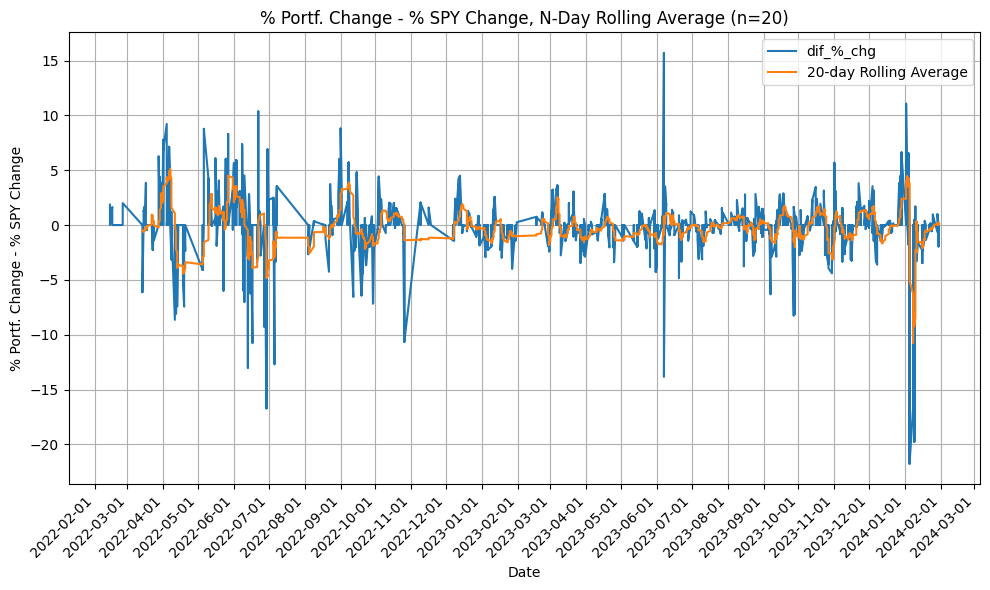

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load and filter data
df = df_model_picks_perf_with_date_sell.copy()  # Create a copy to avoid modifying the original data

# Sort by date
df = df.sort_values(by="date")

# Select data between specified dates (inclusive)
date_start = previous_date_str
date_end = today_str
df = df[(df['date'] >= date_start) & (df['date'] <= date_end)]

# Calculate the rolling average
n_day_window = 20
df["Rolling Average"] = df["dif_%_chg"].rolling(window=n_day_window).mean()

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data and rolling average
plt.plot(df["date"], df["dif_%_chg"], label="dif_%_chg")
plt.plot(df["date"], df["Rolling Average"], label=f"{n_day_window}-day Rolling Average")

# Customize the plot
plt.xlabel("Date")
plt.ylabel("% Portf. Change - % SPY Change")
plt.title(f"% Portf. Change - % SPY Change, N-Day Rolling Average (n={n_day_window})")

# Set major tick locations to monthly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Format date labels
date_form = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_form)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust spacing for better fit

plt.legend()
plt.grid(True)
plt.show()


In [42]:
df

,date,days_lookback,syms_freq,symbols,date_buy,sh_portf_buy,$_portf_buy,sh_SPY_buy,$_SPY_buy,date_sell,sh_portf_sell,$_portf_sell,%_portf_chg,sh_SPY_sell,$_SPY_sell,%_SPY_chg,dif_%_chg,win,Rolling Average
2326,2022-02-14,"[30, 60, 120]",sym_freq_8,['IMO'],2022-02-15,[23.0],958.399605,[2.0],864.812683,2022-02-18,[23.0],950.737705,-0.799447,[2.0],841.801392,-2.660841,1.861394,1,NaN
2325,2022-02-14,"[30, 60, 120]",sym_freq_8,['IMO'],2022-02-15,[23.0],958.399605,[2.0],864.812622,2022-02-18,[23.0],950.737617,-0.799456,[2.0],841.801331,-2.660841,1.861385,1,NaN
2324,2022-02-14,"[30, 60, 120]",sym_freq_8,['IMO'],2022-02-15,[23.0],958.399605,[2.0],864.812683,2022-02-18,[23.0],950.737705,-0.799447,[2.0],841.801392,-2.660841,1.861394,1,NaN
2323,2022-02-14,"[30, 60, 120]",sym_freq_8,['IMO'],2022-02-15,[23.0],950.737705,[2.0],841.801392,2022-02-18,[23.0],950.737705,0.000000,[2.0],841.801392,0.000000,0.000000,0,NaN
2322,2022-02-16,"[30, 60, 120]",sym_freq_8,['IMO'],2022-02-17,[23.0],967.156212,[2.0],847.287659,2022-02-23,[23.0],949.643173,-1.810777,[2.0],817.995239,-3.457199,1.646422,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2024-01-30,"[30, 60, 120]",sym_freq_9,['SHV'],2024-01-31,[9.0],990.873001,[2.0],965.760010,2024-02-05,[9.0],991.350014,0.048141,[2.0],985.099976,2.002564,-1.954424,0,0.088601
20,2024-01-30,"[30, 60, 120]",sym_freq_9,['SHV'],2024-01-31,[9.0],990.873001,[2.0],965.760010,2024-02-05,[9.0],991.350014,0.048141,[2.0],985.099976,2.002564,-1.954424,0,0.018824
19,2024-01-30,"[30, 60, 120]",sym_freq_8,"['ANF', 'FTSM']",2024-01-31,"[4.0, 8.0]",885.279999,[2.0],965.760010,2024-02-05,"[4.0, 8.0]",903.399994,2.046810,[2.0],985.099976,2.002564,0.044245,1,0.021036
17,2024-01-30,"[30, 60, 120]",sym_freq_8,"['ANF', 'FTSM']",2024-01-31,"[4.0, 8.0]",885.279999,[2.0],965.760010,2024-02-05,"[4.0, 8.0]",903.399994,2.046810,[2.0],985.099976,2.002564,0.044245,1,0.051193
